# Whatsapp Group Chat Data Analysis using python.

Hey there! This a project which would keep evolving with time.

A typical data science project would involve **5** steps.
The first step is **Data Collection**. In this case Data collection involves
1.   Opening Whatsapp group chat.
2.   Go to Settings.
3.   Click on Export Chat.
4.   Click on without media.


In [0]:
import re
import pandas as pd

# **Data Preparation:**


This plain text file will have to be parsed and tokenized in a meaningful manner in order to be served (stored) in a Pandas dataframe.

Let us consider just a single line from the text (which we will call “raw text”) and see how we can extract relevant columns from it:

18/06/17, 9:47 PM - Teja: Why do you have 2 numbers?

In our sample line of text, our main objective is to automatically break down the raw message into 4 tokens.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {9:47 PM} - {Teja}: {Why do you have 2 numbers?}






**1) Detecting date and time tokens**

In [0]:
def startsWithDateAndTime(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9][0-9]), ([0-9]+):([0-9][0-9]) (AM|PM) -'
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [0]:
startsWithDateAndTime('1/26/18, 6:34 PM - Teja: add rohit int the grp')

True

**2) Detecting Author Token**

In [0]:
def startsWithAuthor(s):
    patterns = [
        '([\w]+):',                        # First Name
        '([\w]+[\s]+[\w]+):',              # First Name + Last Name
        '([\w]+[\s]+[\w]+[\s]+[\w]+):',    # First Name + Middle Name + Last Name
        '([+]\d{2} \d{5} \d{5}):',         # Mobile Number (India)
        '([+]\d{2} \d{3} \d{3} \d{4}):',   # Mobile Number (US)
        '([+]\d{2} \d{4} \d{7})',
        '([\w]+)[\u263a-\U0001f645]+:',
        '([\w]+) [\u263a-\U0001f645]+:',
        '([\w]+[\s]+[\w]+)[\u263a-\U0001f645]+:',
        '([\w]+[\s]+[\w]+[\s]+[\w]+)[\u263a-\U0001f645]+:',                
    ]
    pattern = '^' + '|'.join(patterns)
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [0]:
startsWithAuthor('Teja: Chhapaak ela untadhi')

True

Before we ran the **startsWithAuthor** method, 2 tokens had been detected in our processed sample message.

{Date}, {Time} -Message

{18/06/17}, {22:47} - {Loki: Why do you have 2 numbers, Banner?}

After we run the **startsWithAuthor** method, 4 tokens are detected in our processed sample message.

{Date}, {Time} - {Author}: {Message}

{18/06/17}, {22:47} - {Loki}: {Why do you have 2 numbers, Banner?}

Once we have detected the Date, Time and Author tokens, what we are left with is the remaining portion of the string which is the Message token.

**3) Extracting and Combining Tokens**

Now that we have been able to identify the Date, Time, Author and Message tokens in a single message, it is time to split each line based on the separator tokens like commas (,), hyphens(-), colons(:) and spaces( ), so that the required tokens can be extracted and saved in a dataframe.

In [0]:
def getDataPoint(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if startsWithAuthor(message): 
        splitMessage = message.split(': ') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message


In [0]:
getDataPoint('4/1/19, 7:43 PM - Mani 💎: Roll back')

('4/1/19', '7:43 PM', 'Mani 💎', 'Roll back')

**Step 4: Parsing the entire file**

 Here we will read the entire whatsapp text file, identify and extract tokens from each line and capture all data in tabular format.

In [0]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/content/drive/My Drive/Colab Notebooks/WhatsApp Chat with Blabla.txt' 
with open(conversationPath, encoding="utf-8") as fp:
    fp.readline() # Skipping first line of the file because contains information related to something about end-to-end encryption
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        line = line.strip() 
        if startsWithDateAndTime(line): 
            if len(messageBuffer) > 0: 
                parsedData.append([date, time, author, ' '.join(messageBuffer)]) 
            messageBuffer.clear() 
            date, time, author, message = getDataPoint(line) 
            messageBuffer.append(message) 
        else:
            messageBuffer.append(line)


# **Data Exploration**

In [0]:
df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
df

,Date,Time,Author,Message
0,3/7/19,6:45 PM,None,"Aakarsh Yelisetty created group ""Blabla"""
1,4/1/19,7:33 PM,None,Aakarsh Yelisetty added you
2,4/1/19,7:40 PM,Mani 💎,Hello hackers 👨🏻‍💻👨🏻‍💻
3,4/1/19,7:43 PM,Mani 💎,"Em ina pedthe, topper ga.. Hacker ga.. Racha l..."
4,4/1/19,7:43 PM,Mani 💎,Roll back
...,...,...,...,...
16059,3/7/20,7:09 PM,Teja Kura,Apatki apud plan cheptar ra ayya
16060,3/7/20,7:09 PM,Mani 💎,<Media omitted>
16061,3/7/20,7:10 PM,Mani 💎,Endra ayya.. anni nen lenappude ithunnai
16062,3/7/20,7:10 PM,Teja Kura,Siddipet kelli ochiru ma cousins andaru


In [0]:
df.describe()

,Date,Time,Author,Message
count,16064,16064,16047,16064
unique,269,1051,5,12846
top,7/26/19,6:47 PM,Vishal Gurrala,<Media omitted>
freq,738,61,4214,689


**Printing participants of the group**

In [0]:
df.Author.unique() 

array([None, 'Mani 💎', 'Aakarsh Yelisetty', 'Vishal Gurrala',
       'Gowtham Bujjam', 'Teja Kura'], dtype=object)

**None** which is the first element in array indicates few messages which do not have authors like,


*   Group was created.
*   Teja was added and so on.



**The most garrulous person award goes to -**

In [0]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
print(df['Author'].value_counts())



Vishal Gurrala       4214
Teja Kura            4094
Mani 💎               3206
Aakarsh Yelisetty    2369
Gowtham Bujjam       2164
Name: Author, dtype: int64


**Visualisation of the above stats**

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0, flags=flags)


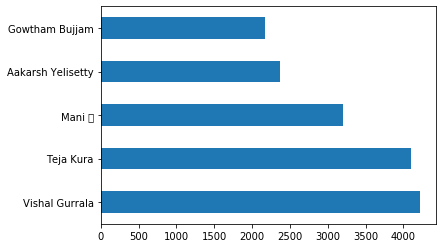

In [33]:
author_value_counts = df['Author'].value_counts() # Number of messages per author
author_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

**Lets have a look at all the 'None' author's messages -**

In [30]:
null_authors_df = df[df['Author'].isnull()]
null_authors_df.head()

,Date,Time,Author,Message
0,3/7/19,6:45 PM,None,"Aakarsh Yelisetty created group ""Blabla"""
1,4/1/19,7:33 PM,None,Aakarsh Yelisetty added you
299,4/11/19,11:10 AM,None,You changed this group's icon
1486,5/3/19,10:24 AM,None,Aakarsh Yelisetty changed this group's icon
2582,5/19/19,7:18 PM,None,Vishal Gurrala changed the group description


**What about the Media Messages?**

In [29]:
media_messages_df = df[df['Message'] == '<Media omitted>']
print(media_messages_df.head())

author_media_messages_value_counts = media_messages_df['Author'].value_counts()
print(author_media_messages_value_counts)
##top_10_author_media_messages_value_counts = author_media_messages_value_counts.head(10)
##top_10_author_media_messages_value_counts.plot.barh()

        Date      Time             Author          Message
14    4/1/19   8:26 PM     Vishal Gurrala  <Media omitted>
28    4/1/19   8:31 PM             Mani 💎  <Media omitted>
29    4/1/19   8:33 PM  Aakarsh Yelisetty  <Media omitted>
30    4/1/19   8:28 PM             Mani 💎  <Media omitted>
284  4/11/19  11:00 AM  Aakarsh Yelisetty  <Media omitted>
Teja Kura            245
Mani 💎               191
Aakarsh Yelisetty    166
Vishal Gurrala        53
Gowtham Bujjam        34
Name: Author, dtype: int64


**Visualisation of the above stats**

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0, flags=flags)


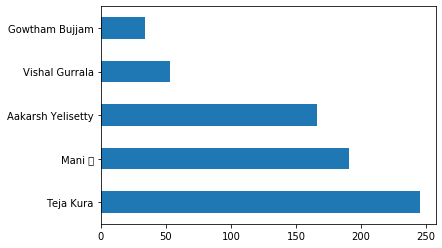

In [36]:
media_value_counts = media_messages_df['Author'].value_counts() # Number of messages per author
media_value_counts.plot.barh() # Plot a bar chart using pandas built-in plotting apis

**We don’t need media nor 'None' author's messages.**

Since we are just restricting ourselves just to the analysis of text-only messages sent by our friends in the group, let us create a new data frame (messages_df) by dropping all those messages that are either media messages or do not have an author,

In [39]:
messages_df = df.drop(null_authors_df.index) # Drops all rows of the data frame containing messages from null authors
messages_df = messages_df.drop(media_messages_df.index) # Drops all rows of the data frame containing media messages
messages_df.head()

,Date,Time,Author,Message
2,4/1/19,7:40 PM,Mani 💎,Hello hackers 👨🏻‍💻👨🏻‍💻
3,4/1/19,7:43 PM,Mani 💎,"Em ina pedthe, topper ga.. Hacker ga.. Racha l..."
4,4/1/19,7:43 PM,Mani 💎,Roll back
5,4/1/19,7:43 PM,Mani 💎,Ventane anni delete chesi dengude
6,4/1/19,7:43 PM,Aakarsh Yelisetty,😂


This step could be categorized as **data cleaning.**

It might be interesting to count the number of letters and words used by each author in each message. So, let us add 2 new columns to the data frame called “Letter_Count” and “Word_Count”, using the following code:

In [0]:
messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))

**How many words have been used by authors since beginning**

Text(0, 0.5, 'Authors')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0, flags=flags)


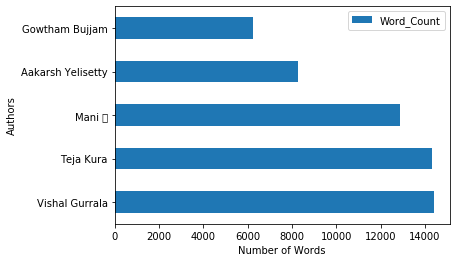

In [41]:
import matplotlib.pyplot as plt
total_word_count_grouped_by_author = messages_df[['Author', 'Word_Count']].groupby('Author').sum()
sorted_total_word_count_grouped_by_author = total_word_count_grouped_by_author.sort_values('Word_Count', ascending=False)
top_10_sorted_total_word_count_grouped_by_author = sorted_total_word_count_grouped_by_author.head(10)
top_10_sorted_total_word_count_grouped_by_author.plot.barh()
plt.xlabel('Number of Words')
plt.ylabel('Authors')

**What is the most common number of words in a message?**

Text(0, 0.5, 'Frequency')

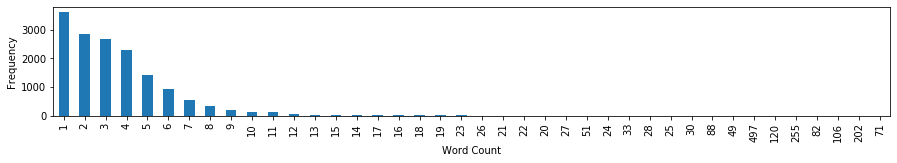

In [0]:
plt.figure(figsize=(15, 2)) # To ensure that the bar plot fits in the output cell of a Jupyter notebook
word_count_value_counts = messages_df['Word_Count'].value_counts()
top_40_word_count_value_counts = word_count_value_counts.head(40)
top_40_word_count_value_counts.plot.bar()
plt.xlabel('Word Count')
plt.ylabel('Frequency')

**The most happening day was -**

7/26/19    720
8/18/19    433
8/12/19    409
7/28/19    344
5/7/19     339
          ... 
9/30/19      1
3/1/20       1
4/28/19      1
4/15/19      1
9/9/19       1
Name: Date, Length: 264, dtype: int64


Text(0, 0.5, 'Date')

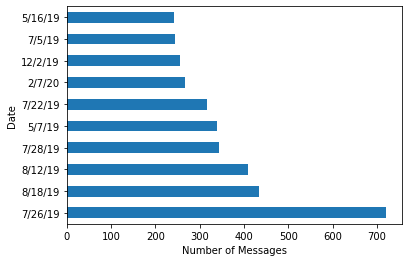

In [42]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

**When are the group members most active?**

Text(0, 0.5, 'Time')

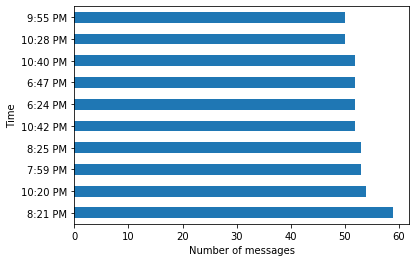

In [0]:
messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

The chance of you gettinga reply at 8:21 PM seem to be damn high!

**Hour of the day!**

Text(0, 0.5, 'Hour of Day')

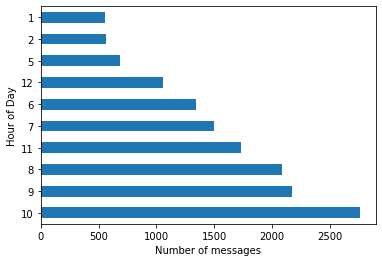

In [43]:
messages_df['Hour'] = messages_df['Time'].apply(lambda x : x.split(':')[0]) # The first token of a value in the Time Column contains the hour (Eg., "20" in "20:15")
messages_df['Hour'].value_counts().head(10).plot.barh() # Top 10 Hours of the day during which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Hour of Day')

**The most used word is -**

In [44]:
from collections import Counter
Counter(" ".join(messages_df["Message"]).split()).most_common(25)

[('ra', 1469),
 ('ga', 650),
 ('kuda', 520),
 ('ani', 429),
 ('ki', 415),
 ('anta', 403),
 ('la', 367),
 ('em', 318),
 ('Nen', 318),
 ('eh', 286),
 ('😂', 277),
 ('kada', 276),
 ('le', 263),
 ('lo', 246),
 ('undi', 210),
 ('ante', 199),
 ('Arey', 193),
 ('Em', 191),
 ('endi', 187),
 ('Teja', 166),
 ('ah', 165),
 ('ne', 163),
 ('and', 151),
 ('gadu', 146),
 ('Vishal', 146)]

**The emoji guy award goes to -**

         Date  ...                                            Message
2      4/1/19  ...                             Hello hackers 👨🏻‍💻👨🏻‍💻
6      4/1/19  ...                                                  😂
12     4/1/19  ...  telvakunte edi sudandi.. nak ithe eppude telsi...
24     4/1/19  ...                 Good manikanta👏🏻keep ur good work😁
26     4/1/19  ...                               Kick this guy I say😂
...       ...  ...                                                ...
15965  3/6/20  ...                                                😂😂😂
15971  3/6/20  ...                                                  😱
15987  3/7/20  ...                                840 nundi unna ra☹️
15988  3/7/20  ...                                                 😂😂
16063  3/7/20  ...  Susheel intla parents unnar anta Manam andaram...

[1323 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 128142 missing from current font.
  font.set_text(s, 0, flags=flags)


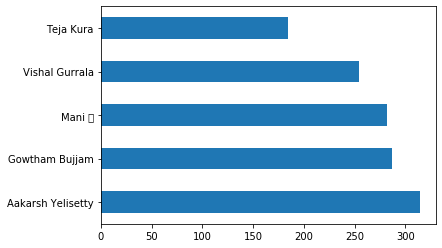

In [47]:
emoji_messages_df = df[df['Message'].str.contains(r"[\u263a-\U0001f645]+", na=False)]
print(emoji_messages_df)
author_emoji_messages_value_counts = emoji_messages_df['Author'].value_counts()
author_emoji_messages_value_counts.plot.barh()

# **Stay tuned! To be continued.**